# US testing: Exploratory Data Analysis

In [1]:
import pandas as pd
import numpy as np
from scipy.optimize import minimize

from matplotlib import pyplot as plt
from matplotlib.dates import date2num, num2date
from matplotlib import dates as mdates
from matplotlib import ticker
from matplotlib.colors import ListedColormap
from matplotlib.patches import Patch

from scipy import stats as sps
from scipy.interpolate import interp1d

from IPython.display import clear_output

FILTERED_REGIONS = [
    'VI',
    'AS',
    'MP',
    'GU',
    'PR']

# US Data; extract testing information

Load US state case data from the covidtracking website which includes positive and negative testing information.

In [2]:
url = 'https://covidtracking.com/api/v1/states/daily.csv'
states = pd.read_csv(url,
                     usecols=[0,1,2,3,22],
                     index_col=['state', 'date'],
                     parse_dates=['date'],
                     squeeze=True).sort_index()

## Data cleaning

For each state, we find the last zero new case day and start our analysis on the day after that. Also, case reporting is very erratic based on testing backlogs, etc. To address this, we apply a gaussian filter to the time series. 

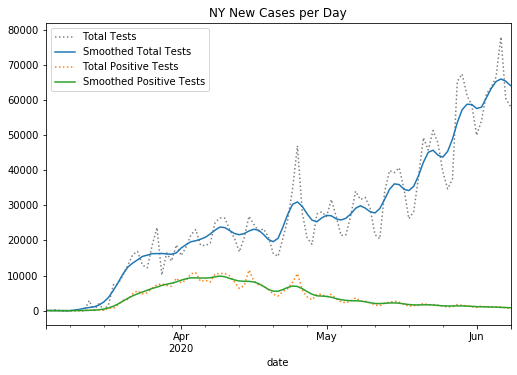

In [3]:
state_name = 'NY'

def prepare_cases(cases):
    new_cases = cases.diff()

    smoothed = new_cases.rolling(7,
        win_type='gaussian',
        min_periods=1,
        center=True).mean(std=2).round()
    
    zeros = smoothed.index[smoothed.eq(0)]
    if len(zeros) == 0:
        idx_start = 0
    else:
        last_zero = zeros.max()
        idx_start = smoothed.index.get_loc(last_zero) + 1
    smoothed = smoothed.iloc[idx_start:]
    original = new_cases.loc[smoothed.index]
    
    return original, smoothed

total = states.xs(state_name)['total'].rename(f"{state_name} cases")
positive = states.xs(state_name)['positive'].rename(f"{state_name} positive cases")

original_total, smoothed_total = prepare_cases(total)
original_positive, smoothed_positive = prepare_cases(positive)

original_total.plot(title=f"{state_name} New Cases per Day",
               c='k',
               linestyle=':',
               alpha=.5,
               label='Total Tests',
               legend=True,
             figsize=(600/72, 400/72))

ax = smoothed_total.plot(label='Smoothed Total Tests',
                   legend=True)
ax.get_figure().set_facecolor('w')

ax2 = original_positive.plot(label='Total Positive Tests', linestyle=':', legend=True)
ax2.get_figure().set_facecolor('w')

ax3 = smoothed_positive.plot(label='Smoothed Positive Tests',
                            legend=True)
ax3.get_figure().set_facecolor('w')

plt.savefig('./figs/NY_casecount.png')

In [4]:
# Calculations for section "Estimation of Data Quality for NY"

print("Total number of positive tests on April 20th: %s" % (smoothed_positive['2020-04-20']))
print("Total number of total tests on April 20th: %s" % (smoothed_total['2020-04-20']))
prevalence = smoothed_positive['2020-04-20']/smoothed_total['2020-04-20']
print("Fraction of  number of positive tests on April 20th: %s" % (np.round(prevalence,3)))
print("")
true_prev = 0.139

def data_quality(FN, FP):

    adj_prevalence = (prevalence - FP)/(1-FP-FN)
    print("Adjusted estimate of prevalence under FP = %s and FN = %s: %s" % (FP, FN, np.round(adj_prevalence,3)))


    adj_true_prev = (true_prev - FP)/(1-FP-FN)
    print("Adjusted true prevalence under FP = %s and FN = %s: %s" % (FP, FN, np.round(adj_true_prev,3)))

    error = (adj_prevalence - adj_true_prev)
    print("Raw error under FP = %s and FN = %s: %s" % (FP, FN, np.round(error,4)))
    
    NY_f = 0.001 # Approximate sampling fraction for NY on April 20th
    sigma_Y = np.sqrt(adj_true_prev*(1-adj_true_prev)) 

    RHS = np.sqrt(NY_f/(1-NY_f)) * error/sigma_Y # RHS 
    print("Error under FP = %s and FN = %s: %s" % (FP, FN, np.round(RHS,4)))

    Delta = 1.06 * np.power(10.,-3)

    def solveDelta(Delta, error):
        f0 = NY_f - adj_true_prev * Delta
        f1 = Delta + f0
        rho = Delta * sigma_Y / np.sqrt(NY_f*(1-NY_f))
        oddsratio = adj_true_prev/(1-adj_true_prev)
        numerator = FP*(1-adj_true_prev)+FN*adj_true_prev
        denominator = f0*(1-adj_true_prev)+f1*adj_true_prev
        D_M1 = 1 - Delta * oddsratio * numerator/denominator
        D_M2 = 1/(1-FP-FN)
        D_M = D_M1 * D_M2
        return np.power((D_M*rho - error),2)

    f=lambda x: solveDelta(x,RHS)
    result=minimize(f,Delta,method='L-BFGS-B',options={'maxiter':1000,'ftol':1e-10})
    Delta_optimal = result['x'][0]
    print("Delta estimate under FP = %s and FN = %s: %s" % (FP, FN, np.round(Delta_optimal,5)))

    def DeltatoM(Delta, f, barY):
        f0 = f - barY * Delta 
        f1 = Delta + f0
        M = f1/f0
        return M
    
    print("Relative sampling rate (M) estimate under FP = %s and FN = %s: %s" % (FP, FN, np.round(DeltatoM(Delta_optimal, NY_f, adj_true_prev),2)))
    print("")

## Estimates for range from Santa Clara study
data_quality(FN= 0.172, FP=0.005)
data_quality(FN= 0.240, FP=0.003)
data_quality(FN= 0.116, FP=0.008)

## Estimate under additional example where FN is lower than FP
data_quality(FP=0.05, FN= 0.005)


Total number of positive tests on April 20th: 5581.0
Total number of total tests on April 20th: 19654.0
Fraction of  number of positive tests on April 20th: 0.284

Adjusted estimate of prevalence under FP = 0.005 and FN = 0.172: 0.339
Adjusted true prevalence under FP = 0.005 and FN = 0.172: 0.163
Raw error under FP = 0.005 and FN = 0.172: 0.1761
Error under FP = 0.005 and FN = 0.172: 0.0151
Delta estimate under FP = 0.005 and FN = 0.172: 0.00107
Relative sampling rate (M) estimate under FP = 0.005 and FN = 0.172: 2.3

Adjusted estimate of prevalence under FP = 0.003 and FN = 0.24: 0.371
Adjusted true prevalence under FP = 0.003 and FN = 0.24: 0.18
Raw error under FP = 0.003 and FN = 0.24: 0.1915
Error under FP = 0.003 and FN = 0.24: 0.0158
Delta estimate under FP = 0.003 and FN = 0.24: 0.00099
Relative sampling rate (M) estimate under FP = 0.003 and FN = 0.24: 2.21

Adjusted estimate of prevalence under FP = 0.008 and FN = 0.116: 0.315
Adjusted true prevalence under FP = 0.008 and FN 

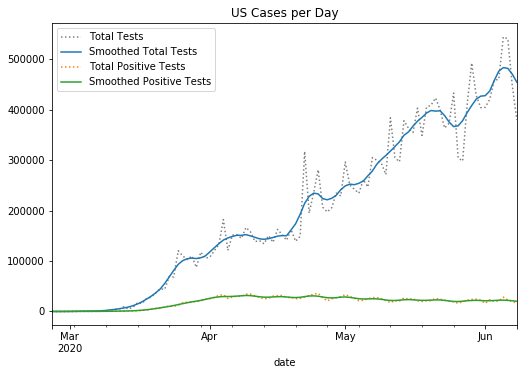

In [5]:
UStotals = states.groupby(level='date').sum()

UStotal = UStotals['total'].astype("float64")
USpositive = UStotals['positive'].astype("float64")

USoriginal_total, USsmoothed_total = prepare_cases(UStotal)
USoriginal_positive, USsmoothed_positive = prepare_cases(USpositive)

USoriginal_total.plot(title="US Cases per Day",
               c='k',
               linestyle=':',
               alpha=.5,
               label='Total Tests',
               legend=True,
             figsize=(600/72, 400/72))

ax = USsmoothed_total.plot(label='Smoothed Total Tests',
                           legend=True)
ax.get_figure().set_facecolor('w')

ax2 = USoriginal_positive.plot(label='Total Positive Tests', linestyle=':', legend=True)
ax2.get_figure().set_facecolor('w')

ax3 = USsmoothed_positive.plot(label='Smoothed Positive Tests',
                            legend=True)
ax3.get_figure().set_facecolor('w')

plt.savefig('./figs/US-casecount.png')

In [6]:
# Calculations presented on page 4

cumulative_US = np.sum(USsmoothed_total)
cumulative_US_positive = np.sum(USsmoothed_positive)
US_pop = 312471327.0 # Obtained from the below US population calculation
US_samplingfraction = cumulative_US/US_pop
empirical_prevalence = cumulative_US_positive/cumulative_US
FN = 0.172; FP = 0.005
adj_empirical_prevalence = (empirical_prevalence - FP)/(1 - FP - FN)
print("Fraction of US sampled: %s" % US_samplingfraction)
print("Estimated prevalence in US: %s" % empirical_prevalence)
print("Adj. estimated prevalence in US: %s" % adj_empirical_prevalence)

def effective_ss(M, barY, f, FP, FN):
    adj_barY = (barY - FP)/(1-FP-FN)
    f0 = US_samplingfraction/ (adj_barY * M + (1-adj_barY))
    f1 = M * f0
    Delta = f1 - f0
    sigma_Y = adj_barY * (1-adj_barY)
    rho = Delta * sigma_Y / np.sqrt(f*(1-f))
    oddsratio = adj_barY/(1-adj_barY)
    numerator = FP*(1-adj_barY)+FN*adj_barY
    denominator = f0*(1-adj_barY)+f1*adj_barY
    D_M1 = 1 - Delta * oddsratio * numerator/denominator
    D_M2 = 1/(1-FP-FN)
    D_M = D_M1 * D_M2
    neff = f/(1-f) * 1/(np.power(rho*D_M,2))
    return neff


neff1 = effective_ss(M=2.0, barY=empirical_prevalence, f=US_samplingfraction, FN=0.172, FP=0.005)
neff2 = effective_ss(M=1.2, barY=empirical_prevalence, f=US_samplingfraction, FN=0.172, FP=0.005)
print("Effective sample size is %s or %s when M = 2.0 and M = 1.2 respectively" % (np.round(neff1,0), np.round(neff2,0)))

range_barY = [0.05,0.07,0.09,0.11,0.13]
range_M = [1.2,1.4,1.6,1.8,2.0]
result_noerror = np.zeros((len(range_barY), len(range_M)))
result_mem = np.zeros((len(range_barY), len(range_M)))
for i in range(len(range_barY)):
    for j in range(len(range_M)):
        result_noerror[i,j] = effective_ss(M=range_M[j], barY=range_barY[i], f=US_samplingfraction, FN=0.00, FP=0.00)
        result_mem[i,j] = effective_ss(M=range_M[j], barY=range_barY[i], f=US_samplingfraction, FN=0.172, FP=0.005)

print(np.round(result_noerror,0))

print(np.round(result_mem,0))

Fraction of US sampled: 0.06607575548843879
Estimated prevalence in US: 0.09464725708547565
Adj. estimated prevalence in US: 0.10892740836631307
Effective sample size is 89.0 or 1879.0 when M = 2.0 and M = 1.2 respectively
[[11303.  2882.  1306.   749.   489.]
 [ 6065.  1558.   712.   411.   270.]
 [ 3862.  1000.   460.   268.   177.]
 [ 2724.   711.   329.   193.   129.]
 [ 2057.   541.   252.   149.   100.]]
[[6480. 1656.  752.  432.  282.]
 [3304.  852.  391.  227.  149.]
 [2059.  536.  248.  145.   97.]
 [1440.  379.  177.  104.   70.]
 [1086.  288.  136.   81.   55.]]


In [7]:
neff1 = effective_ss(M=1.2, barY=empirical_prevalence, f=0.05, FN=0.0, FP=0.0)
neff2 = effective_ss(M=1.2, barY=empirical_prevalence, f=0.10, FN=0.0, FP=0.0)
print("Increase factor of effective sample size under FN=0.0 and FP = 0.0: %s" % (np.round(neff2/neff1,2)))

neff1 = effective_ss(M=1.2, barY=empirical_prevalence, f=0.05, FN=0.005, FP=0.005)
neff2 = effective_ss(M=1.2, barY=empirical_prevalence, f=0.10, FN=0.20, FP=0.005)
print("Increase factor of effective sample size under increase in FN and FP rates: %s" % (np.round(neff2/neff1,2)))

Increase factor of effective sample size under FN=0.0 and FP = 0.0: 4.0
Increase factor of effective sample size under increase in FN and FP rates: 1.76


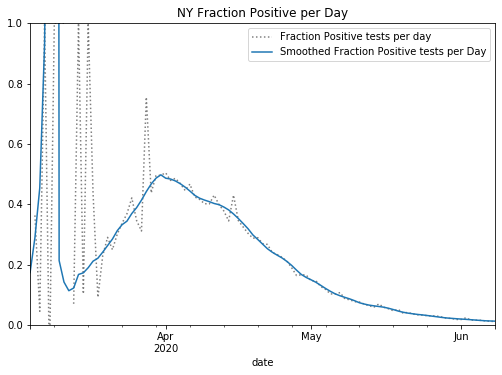

In [8]:
fraction = original_positive/original_total
smoothed_fraction = smoothed_positive/smoothed_total

fraction.plot(title=f"{state_name} Fraction Positive per Day", ylim = (0,1),
               c='k',
               linestyle=':',
               alpha=.5,
               label='Fraction Positive tests per day',
               legend=True,
             figsize=(600/72, 400/72))

ax2 = smoothed_fraction.plot(label='Smoothed Fraction Positive tests per Day',
                            legend=True)
ax2.get_figure().set_facecolor('w')

plt.savefig('./figs/NY_fracpos.png')

In [9]:
def plot_frac(result, ax, state_name):
    
    ax.set_title(f"{state_name}")
    
    # Colors
    ABOVE = [1,0,0]
    MIDDLE = [1,1,1]
    BELOW = [0,0,0]
    cmap = ListedColormap(np.r_[
        np.linspace(BELOW,MIDDLE,25),
        np.linspace(MIDDLE,ABOVE,25)
    ])
    color_mapped = lambda y: np.clip(y, .5, 1.5)-.5
    
    index = result['frac'].index.get_level_values('date')
    values = result['frac'].values
    
    # Plot dots and line
    ax.plot(index, values, c='k', zorder=1, alpha=.25)
    ax.scatter(index,
               values,
               s=40,
               lw=.5,
               c=cmap(color_mapped(values)),
               edgecolors='k', zorder=2)
    
    # Formatting
    ax.xaxis.set_major_locator(mdates.MonthLocator())
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%b'))
    ax.xaxis.set_minor_locator(mdates.DayLocator())
    
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_formatter(ticker.StrMethodFormatter("{x:.1f}"))
    ax.yaxis.tick_right()
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.margins(0)
    ax.grid(which='major', axis='y', c='k', alpha=.1, zorder=-2)
    ax.margins(0)
    ax.set_ylim(0.0,1.0)
    ax.set_xlim(pd.Timestamp('2020-03-01'), result.index.get_level_values('date')[-1]+pd.Timedelta(days=1))
    fig.set_facecolor('w')

## Fraction of total tests that are positive: plots for each state

In [10]:
results = {}

states_to_process = states.loc[~states.index.get_level_values('state').isin(FILTERED_REGIONS)]

state_name = states_to_process.groupby(level='state')

for state_name, cases in states_to_process.groupby(level='state'):
    clear_output(wait=True)
    print(f'Processing {state_name}')
    tot, smoothed_tot = prepare_cases(cases.total)
    pos, smoothed_pos = prepare_cases(cases.positive)
    pos_frac = smoothed_pos/smoothed_tot
    pos_frac[np.isnan(pos_frac)] = 0.0
    result = pd.DataFrame(pos_frac, columns=['frac'])
    results[state_name] = result.droplevel(0)
    
clear_output(wait=True)
print('Done.')

Done.


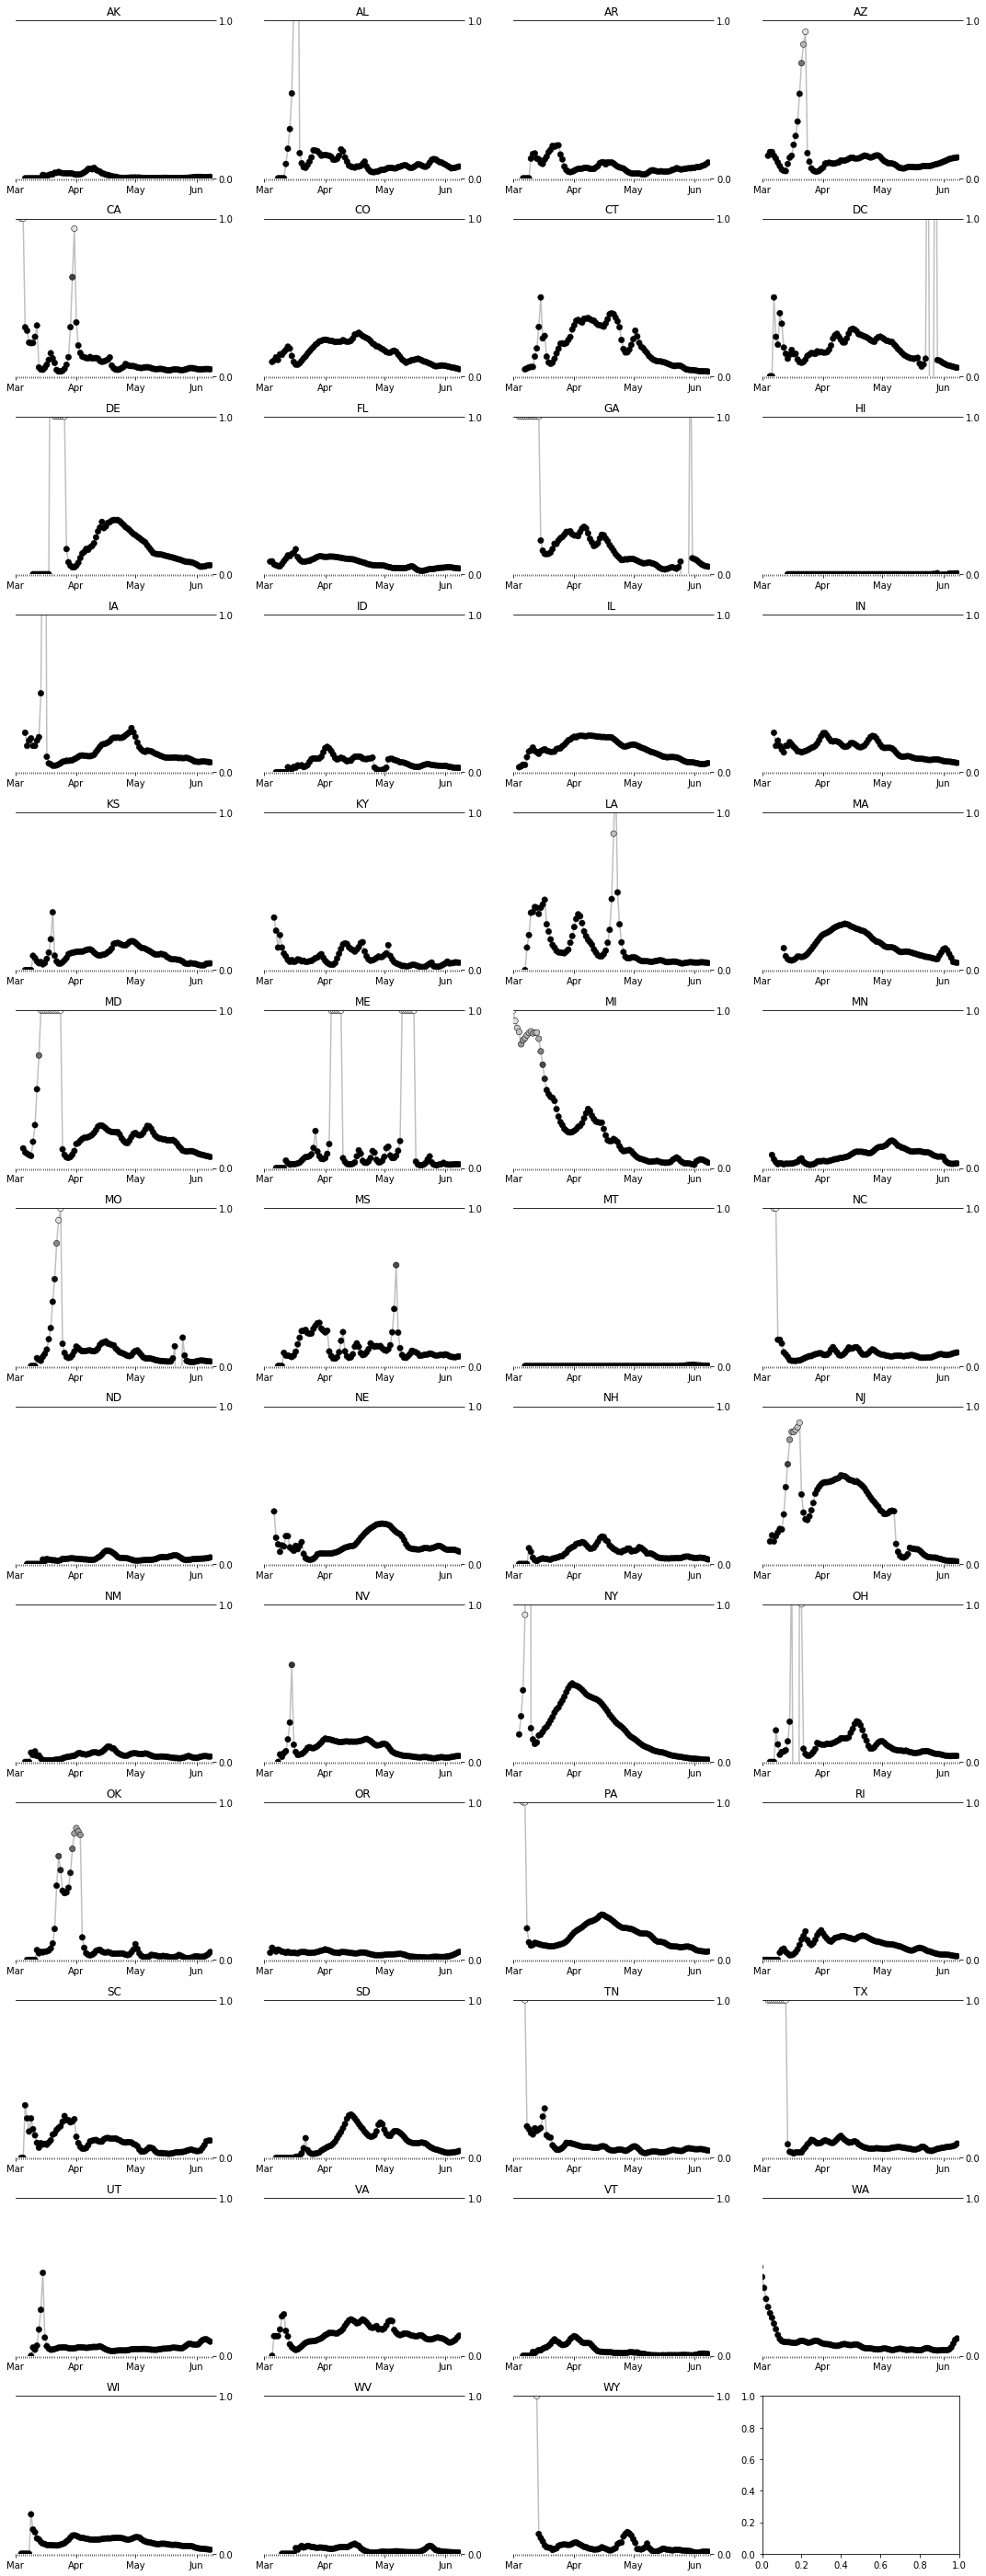

In [11]:
ncols = 4
nrows = int(np.ceil(len(results) / ncols))

fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=(15, nrows*3))

for i, (state_name, result) in enumerate(results.items()):
    plot_frac(result, ax.flat[i], state_name)
    
fig.tight_layout()
fig.set_facecolor('w')

## Bring in state population data

In [12]:
urlpop = 'http://www2.census.gov/programs-surveys/popest/datasets/2010-2019/national/totals/nst-est2019-alldata.csv?#'
state_pop = pd.read_csv(urlpop,
                        usecols=[4,5],
                        squeeze=True).sort_index()
state_pop.columns = ['name', 'pop']

us_state_abbrev = {
    'Alabama': 'AL',
    'Alaska': 'AK',
    'American Samoa': 'AS',
    'Arizona': 'AZ',
    'Arkansas': 'AR',
    'California': 'CA',
    'Colorado': 'CO',
    'Connecticut': 'CT',
    'Delaware': 'DE',
    'District of Columbia': 'DC',
    'Florida': 'FL',
    'Georgia': 'GA',
    'Guam': 'GU',
    'Hawaii': 'HI',
    'Idaho': 'ID',
    'Illinois': 'IL',
    'Indiana': 'IN',
    'Iowa': 'IA',
    'Kansas': 'KS',
    'Kentucky': 'KY',
    'Louisiana': 'LA',
    'Maine': 'ME',
    'Maryland': 'MD',
    'Massachusetts': 'MA',
    'Michigan': 'MI',
    'Minnesota': 'MN',
    'Mississippi': 'MS',
    'Missouri': 'MO',
    'Montana': 'MT',
    'Nebraska': 'NE',
    'Nevada': 'NV',
    'New Hampshire': 'NH',
    'New Jersey': 'NJ',
    'New Mexico': 'NM',
    'New York': 'NY',
    'North Carolina': 'NC',
    'North Dakota': 'ND',
    'Northern Mariana Islands':'MP',
    'Ohio': 'OH',
    'Oklahoma': 'OK',
    'Oregon': 'OR',
    'Pennsylvania': 'PA',
    'Puerto Rico': 'PR',
    'Rhode Island': 'RI',
    'South Carolina': 'SC',
    'South Dakota': 'SD',
    'Tennessee': 'TN',
    'Texas': 'TX',
    'Utah': 'UT',
    'Vermont': 'VT',
    'Virgin Islands': 'VI',
    'Virginia': 'VA',
    'Washington': 'WA',
    'West Virginia': 'WV',
    'Wisconsin': 'WI',
    'Wyoming': 'WY'
}

## Build a joint dataframe of population size data and testing data

In [13]:
results = np.array([])
for i in range(state_pop.shape[0]):
    row = state_pop.iloc[i]
    try:
        state_name = us_state_abbrev[row['name']]
        total = max(states.xs(state_name)['total'].rename(f"{state_name} cases"))
        positive = max(states.xs(state_name)['positive'].rename(f"{state_name} cases") )
        frac = positive/total
        pop = row['pop']
        results = np.concatenate((results, [state_name, total, positive, frac, pop]))
    except:
        continue

cum_df = pd.DataFrame(np.reshape(results, (-1,5)), columns = ['state', 'total', 'positive', 'frac', 'population'])

print("US total population: %s" % np.sum(np.array(cum_df['population'], dtype = 'float64')))

US total population: 312471327.0


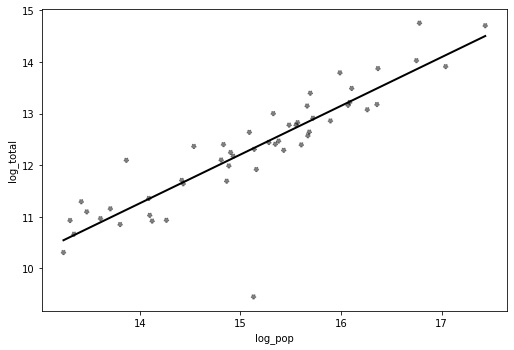

In [14]:
cum_df['log_pop'] = np.log(cum_df['population'].astype(float))
cum_df['log_pos'] = np.log(cum_df['positive'].astype(float))
cum_df['log_total'] = np.log(cum_df['total'].astype(float))
cum_df['frac'] = cum_df['frac'].astype(float)

x_name = 'log_pop'; y_name = 'log_total'
cum_df.plot(x=x_name,y=y_name,kind = 'scatter', 
           c='k', linestyle=':', alpha=.5, figsize=(600/72, 400/72))

pltmin = np.min(cum_df[x_name])
pltmax = np.max(cum_df[x_name])

(slope, intercept, rvalue, pvalue, stderr) = sps.linregress(cum_df[x_name],cum_df[y_name])

plt.plot([pltmin, pltmax], [intercept+pltmin*slope, intercept+pltmax*slope], 'k-', lw=2)

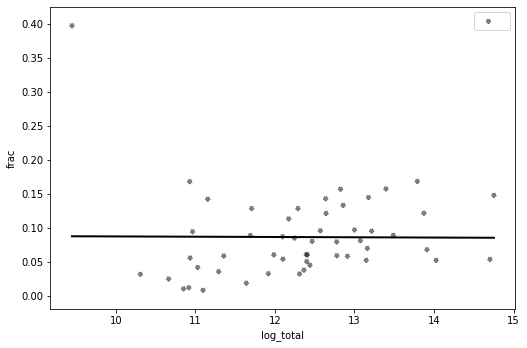

In [15]:
cum_df.plot(x='log_total',y='frac',kind = 'scatter',
           c='k', linestyle=':', alpha=.5, label='', figsize=(600/72, 400/72))

(slope, intercept, rvalue, pvalue, stderr) = sps.linregress(cum_df['log_total'],cum_df['frac'])

pltmin = np.min(cum_df['log_total'])
pltmax = np.max(cum_df['log_total'])
plt.plot([pltmin, pltmax], [intercept+pltmin*slope, intercept+pltmax*slope], 'k-', lw=2)